## Распознавание лиц

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

import cv2 as cv
from sklearn.metrics import classification_report

In [5]:
data_path = fr'C:\ML\DataBases\faces\prep_681'

## Изменение размеры изображений в датасете

In [6]:
batch_size = 16
img_height, img_width = 681, 681

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,  # процент разделения данных на тестовые и тренировочные
    subset='training',  # название
    seed=123,  # семя рандома
    image_size=(img_height, img_width),
    batch_size=batch_size  # количество изображений, считываемых за раз
)

Found 1198 files belonging to 2 classes.
Using 959 files for training.


In [8]:
class_names = train_ds.class_names
class_names

['me', 'others']

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,  # процент разделения данных на тестовые и тренировочные
    subset='validation',  # название
    seed=123,  # семя рандома
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1198 files belonging to 2 classes.
Using 239 files for validation.


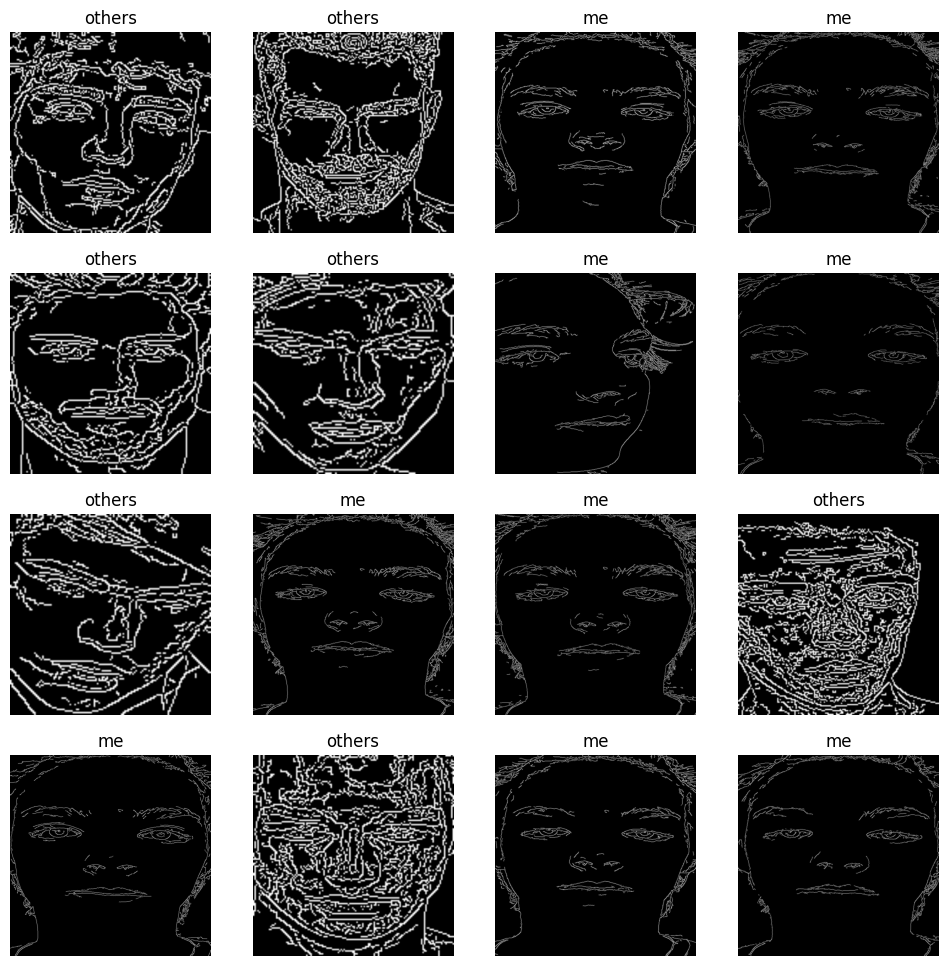

In [10]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE  # константа для оптимизации производительности
# распределитель ресурсов пк (потоки)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# кеширование -> перемешивание -> предварительная загрузка данных в память пк для обучения модели

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = keras.Sequential(  # характеристика того, что надо сделать с изображениями
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

## Дописать precision

In [ ]:
def precision(y_true, y_pred):
    return

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
verbose = True

monitor = 'loss'
min_delta = 0.01
patience = 2

In [16]:
callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose)]

In [17]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=batch_size
)

Epoch 1/5
25/60 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8759 - loss: 0.1100

KeyboardInterrupt: 

In [ ]:
def plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        metric_mean = np.mean(metric[1][-3:])
        val_metric_mean = np.mean(val_metric[1][-3:])

        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.ylim(0, metric_mean + val_metric_mean)
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

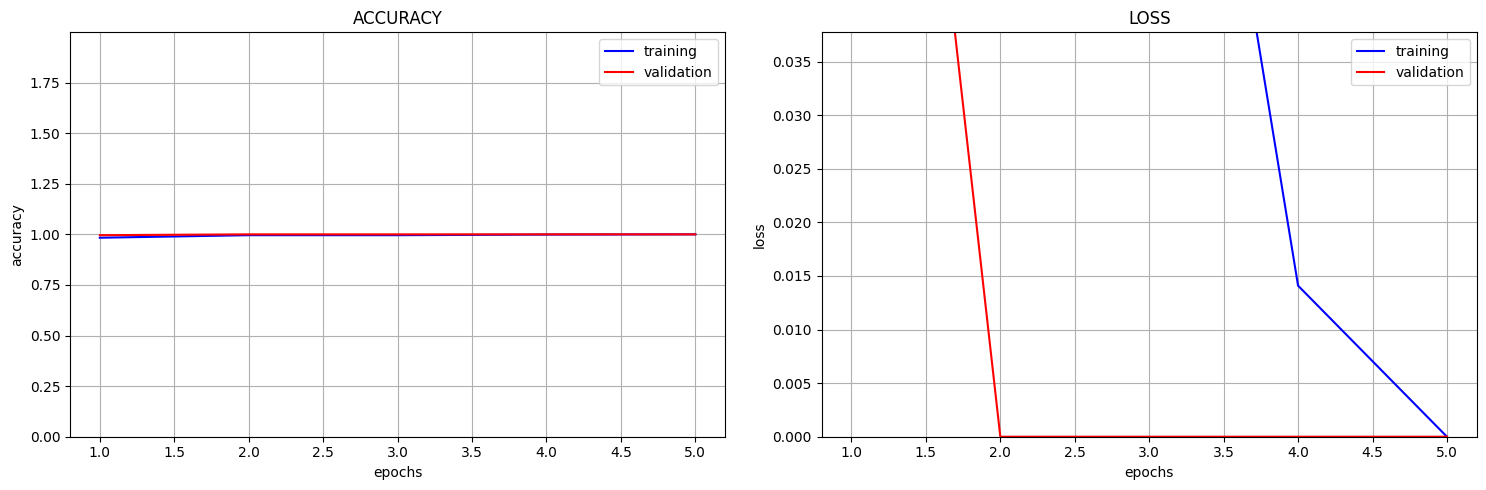

In [ ]:
plot_model_metrics(history)

In [ ]:
res = model.evaluate(val_ds, batch_size=batch_size)
print(f'loss: {res[0]}')
print(f'acc: {res[1]}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 1.0000 - loss: 0.0000e+00
loss: 0.0
acc: 1.0


In [ ]:
im = cv.imread('photo.jpg')
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
img_filter = cv.bilateralFilter(gray, 11, 15, 15)
img = cv.Canny(img_filter, 20, 40)
img = cv.resize(img, (681, 681))
cv.imwrite('new_photo.jpg', img)

True

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"Это изображение на {round(np.max(score) * 100, 2)} % похоже на {class_names[np.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Это изображение на 100.0 % похоже на me


In [ ]:
model.save('face_recogn_model_prep_681.h5')

In [15]:
m = tf.keras.models.load_model('face_recogn_model_prep_681.h5')